# Main

## Import Libraries

In [1]:
# import libraries
import numpy as np
import pandas as pd
import pickle as pkl

import torch
import torch.nn as nn
from torch.nn.functional import one_hot 
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim

from TorchCRF import CRF
import tqdm
import blosum as bl

SAVE = True

## Process Data

In [2]:
# 去除数据中的引号
data = pd.read_csv("./Data/Substrate_search.txt", sep='\t', header=None, encoding='utf-8')
data = data.map(lambda x: str(x).strip("'") if isinstance(x, str) else x)

if SAVE is True:
    data.to_csv("./Data/Substrate_search_processed.csv", sep='\t', index=False, header=False, encoding="utf-8")
data.head(5)

/var/folders/nk/q7smhcns0vz5c_6thgvby85m0000gn/T/ipykernel_96384/2484837789.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("./Data/Substrate_search.txt", sep='\t', header=None, encoding='utf-8')


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,CLE0166975,A01.001,ac-Phe-Tyr(I2),ac-Phe+Tyr(I2),-,-,Ac,Phe,TyI,-,...,NaN,NaN,pepsin A,NaN,NaN,NaN,NaN,NaN,synthetic,NaN
1,CLE0166506,A01.001,alcohol dehydrogenase,peptide-Ala107+Val-peptide,Arg,Thr,Ile,Ala,Val,Asn,...,107,Drosophila melanogaster,pepsin A,NaN,NaN,1-256,NT,VT,non-physiological,NaN
2,CLE0166510,A01.001,alcohol dehydrogenase,peptide-Ala119+Ile-peptide,Thr,Thr,Thr,Ala,Ile,Leu,...,119,Drosophila melanogaster,pepsin A,NaN,NaN,1-256,NT,VT,non-physiological,NaN
3,CLE0166517,A01.001,alcohol dehydrogenase,peptide-Ala178+Tyr-peptide,Gly,Val,Thr,Ala,Tyr,Thr,...,178,Drosophila melanogaster,pepsin A,NaN,NaN,1-256,NT,VT,non-physiological,NaN
4,CLE0166523,A01.001,alcohol dehydrogenase,peptide-Ala218+Cys-peptide,Pro,Ser,Leu,Ala,Cys,Ala,...,218,Drosophila melanogaster,pepsin A,NaN,NaN,1-256,NT,VT,non-physiological,NaN


In [3]:
# 构建氨基酸缩写间的映射
amino_table = pd.read_csv("./Data/amino_table.csv", sep="\t", header=None)
amino_table.columns = ["chinese", "english", "one_abbr", "three_abbr"]
amino_three2one, amino_one2three = dict(), dict()
for row_i, row in amino_table.iterrows():
    three_abbr = row["three_abbr"].lower()
    one_abbr = row["one_abbr"].lower()
    amino_three2one[three_abbr] = one_abbr
    amino_one2three[one_abbr] = three_abbr

In [4]:
# 只保留蛋白酶名和肽链信息
data = pd.read_csv("./Data/Substrate_search_processed.csv", sep='\t', header=None, encoding='utf-8')

protease_peptide = pd.concat((data[[1]], data.iloc[:, 4:12]), axis=1)  # 拼接蛋白酶和肽链信息
protease_peptide = protease_peptide.dropna()  # 删除有nan的行
nan_row_ids = set()  # 获取nan行的索引，部分数据有"NAN"的值，只能手动删除
for row_i, row in protease_peptide.iterrows():
    if "NAN" in row.tolist():
        nan_row_ids |= {row_i}
protease_peptide = protease_peptide.drop(list(nan_row_ids))  # 删除有nan行

protease_peptide.columns = ["protease"] + [i for i in range(8)]  # 修改列名
protease_peptide.iloc[:, 1:] = protease_peptide.iloc[:, 1:].map(lambda x: x.lower())  # 将氨基酸转为小写
protease_peptide.iloc[:, 1:] = protease_peptide.iloc[:, 1:].map(lambda x: "-" if "-" in x else x)  # 将"/-/"转为"-"

# 筛选人体蛋白酶
human_protease = pd.read_csv("./Data/human_protease.txt", sep="\t")
human_protease = set(human_protease["MEROPS ID"].tolist())
human_animos = set(bl.BLOSUM(62).keys())
protease_peptide = protease_peptide[protease_peptide["protease"].isin(human_protease)]

# 筛选只含人体内氨基酸的肽链
valid_row_ids = []
for row_i, row in protease_peptide.iterrows():
    if len(set(row.iloc[1:].map(lambda x: x.lower()).tolist()) - (amino_three2one.keys() | {"-"})) == 0:
        valid_row_ids.append(row_i)
protease_peptide = protease_peptide.loc[valid_row_ids]

if SAVE is True:
    protease_peptide.to_csv("./Data/Protease_Peptides.csv", sep='\t', header=True, index=False)  # 保存数据
protease_peptide.head(5)

/var/folders/nk/q7smhcns0vz5c_6thgvby85m0000gn/T/ipykernel_96384/854187641.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("./Data/Substrate_search_processed.csv", sep='\t', header=None, encoding='utf-8')


,protease,0,1,2,3,4,5,6,7
998,A01.003,phe,gly,asp,leu,ser,val,thr,tyr
999,A01.003,leu,gly,glu,phe,leu,arg,thr,his
1000,A01.003,phe,thr,ser,asp,tyr,ser,lys,tyr
1001,A01.003,val,gln,trp,leu,met,asn,thr,-
1002,A01.003,gln,gly,thr,phe,thr,ser,asp,tyr


## Similar Peptides

In [5]:
# 测试数据中的氨基酸名是否都正确
error_amino = set()
for row_i, row in protease_peptide.iterrows():
    protease_name = row["protease"]
    peptides = row.iloc[1:]
    for peptide in peptides:
        if peptide not in amino_three2one and peptide != "-":
            error_amino |= {peptide}
            print("Error: {} row, {}".format(row_i, peptide))

In [41]:
bl62 = bl.BLOSUM(62)
# 生成相似肽链

# 比较两条肽链之间的相似性
def compare_peptides(pep_source: tuple, pep_target: tuple) -> int:
    # 通过比较替换前和替换后的分数差来比较两条肽链的相似性
    score = 0  # initialize score
    for pep_source_amino, pep_target_amino in zip(pep_source, pep_target):
        # 判断是否为"-":
        if (pep_source_amino == "-") ^ (pep_target_amino == "-"):  # 如果两个肽链有一位是"-"但是另一个不是，则认为距离为负无穷
            valid_amino = list({pep_source_amino, pep_target_amino} - {"-"})[0]
            valid_amino_abbr = amino_three2one[valid_amino].upper()
            score += 0
        else:
            if pep_source_amino == "-":  # 如果两者都是"-"，则分数不变
                pass
            else:
                pep_source_amino_abbr, pep_target_amino_abbr = amino_three2one[pep_source_amino].upper(), amino_three2one[pep_target_amino].upper()  # turn into abbr
                replace_score = bl62[pep_source_amino_abbr][pep_target_amino_abbr]  # 获取替换该氨基酸的分数
                original_score = bl62[pep_source_amino_abbr][pep_source_amino_abbr]  # 获取原始分数
                score += replace_score - original_score
    return score

# MMP3和MMP9和其他肽链的距离

## Data Analysis

In [46]:
# 查找MMP3独有的肽链
MMP3_protease = "M10.005"

# 构建从protease到肽链的映射
proteases = set(protease_peptide["protease"].tolist())
protease2peptides = dict()
for protease in proteases:
    peptides = protease_peptide[protease_peptide["protease"] == protease].iloc[:, 1:].values.tolist()
    peptides = {tuple(x) for x in peptides}
    protease2peptides[protease] = peptides

def search_unique_peptides(protease: str, protease2peptides: dict = protease2peptides) -> set:
    peptides = protease2peptides[protease].copy()  # 必须要复制，不然会改变字典内部的值
    for p in protease2peptides.keys():
        if p != protease:
            peptides -= protease2peptides[p]
    return peptides

len(search_unique_peptides(MMP3_protease))  # original: 1945

1945

In [47]:
# MMP3独有的肽链和其他肽链的距离
other_peptides = set()
for protease in protease2peptides.keys():
    if protease != MMP3_protease:
        other_peptides |= protease2peptides[protease]

mmp3_out_scores = dict()

for mmp3_peptide in search_unique_peptides(MMP3_protease):
    for peptide in other_peptides:
        score = compare_peptides(mmp3_peptide, peptide)
        mmp3_out_scores[(mmp3_peptide, peptide)] = score

In [48]:
# MMP3独有的肽链和自己肽链的距离
mmp3_in_scores = dict()

for mmp3_peptide in search_unique_peptides(MMP3_protease):
    for peptide in search_unique_peptides(MMP3_protease):
        score = compare_peptides(mmp3_peptide, peptide)
        mmp3_in_scores[(mmp3_peptide, peptide)] = score

In [49]:
# MMP3非独有的肽链和其他肽链的距离
mmp3_common_peptides = protease2peptides[MMP3_protease] & other_peptides  # mmp3非独有的肽链
mmp3_common_scores = dict()

for mmp3_peptide in mmp3_common_peptides:
    for peptide in other_peptides:
        score = compare_peptides(mmp3_peptide, peptide)
        mmp3_common_scores[(mmp3_peptide, peptide)] = score

In [50]:
mmp3_in_matrix = np.zeros((1945, 1945))
mmp3_in_peptide_list = list(search_unique_peptides(MMP3_protease))
for (pep1, pep2), score in mmp3_in_scores.items():
    pep1_id = mmp3_in_peptide_list.index(pep1)
    pep2_id = mmp3_in_peptide_list.index(pep2)
    mmp3_in_matrix[pep1_id, pep2_id] = score
    mmp3_in_matrix[pep2_id, pep1_id] = score

In [51]:
# 统计MMP3每个肽链在其他protease中出现的次数
mmp3_peptide_count = dict()
for mmp3_peptide in protease2peptides[MMP3_protease]:
    count = 0
    for protease in protease2peptides.keys():
        if protease != MMP3_protease:
            if mmp3_peptide in protease2peptides[protease]:
                count += 1
    mmp3_peptide_count[mmp3_peptide] = count

# 统计只出现过一次的肽链
occur_1_peptides = {k for k, v in mmp3_peptide_count.items() if v == 1}
occur_2_peptides = {k for k, v in mmp3_peptide_count.items() if v == 2}
occur_more_peptides = {k for k, v in mmp3_peptide_count.items() if v > 2}

# 统计只出现一次的肽链的分数
occur_1_scores = [x for k, x in mmp3_common_scores.items() if k[0] in occur_1_peptides]
occur_2_scores = [x for k, x in mmp3_common_scores.items() if k[0] in occur_2_peptides]
occur_more_scores = [x for k, x in mmp3_common_scores.items() if k[0] in occur_more_peptides]

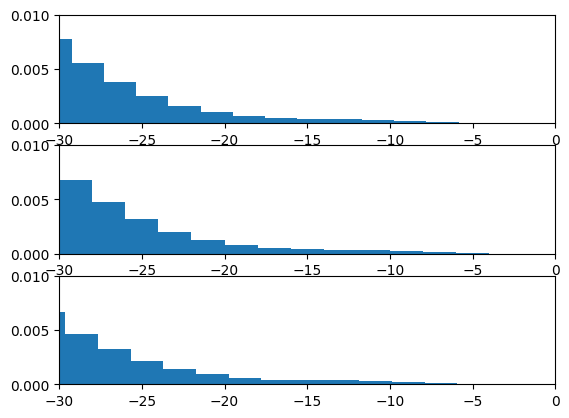

In [54]:
# 绘画曲线
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
fig, axes = plt.subplots(3, 1, dpi=100)
axes[0].hist(occur_1_scores, density=True, bins=40)
axes[1].hist(occur_2_scores, density=True, bins=40)
axes[2].hist(occur_more_scores, density=True, bins=40)
for ax in axes:
    ax.set_xlim(-30, 0)
    ax.set_ylim(0, 0.01)

plt.show()

In [64]:
# 找出每一个protease分数的最大值
mmp3_unique_max_scores = dict()

other_peptides = set()
for protease in protease2peptides.keys():
    if protease != MMP3_protease:
        other_peptides |= protease2peptides[protease]

mmp3_out_scores = dict()

for mmp3_peptide in search_unique_peptides(MMP3_protease):
    peptide_scores = []
    for peptide in other_peptides:
        score = compare_peptides(mmp3_peptide, peptide)
        peptide_scores.append(score)
    peptide_scores = sorted(peptide_scores, reverse=True)
    mmp3_unique_max_scores[mmp3_peptide] = peptide_scores[:5]

mmp3_unique_max_scores = sorted([(k, v) for k, v in mmp3_unique_max_scores.items()], key=lambda x: np.average(x[1]))

In [69]:
mmp3_unique_max_scores[:10]

[(('arg', 'ile', 'phe', 'cys', 'cys', 'arg', 'ser', 'gly'),
  [-11.0, -12.0, -18.0, -19.0, -19.0]),
 (('tyr', 'met', 'ala', 'cys', 'cys', 'leu', 'leu', 'tyr'),
  [-11.0, -12.0, -18.0, -18.0, -19.0]),
 (('trp', 'cys', 'gly', 'his', 'cys', 'lys', 'arg', 'leu'),
  [-11.0, -15.0, -16.0, -16.0, -18.0]),
 (('ala', 'val', 'ala', 'his', 'cys', 'lys', 'arg', 'gly'),
  [-11.0, -15.0, -16.0, -16.0, -18.0]),
 (('trp', 'cys', 'gly', 'his', 'cys', 'lys', 'lys', 'leu'),
  [-11.0, -15.0, -15.0, -16.0, -18.0]),
 (('tyr', 'val', 'lys', 'asn', 'cys', 'phe', 'arg', 'met'),
  [-14.0, -14.0, -15.0, -15.0, -15.0]),
 (('leu', 'gln', 'ala', 'asn', 'cys', 'tyr', 'glu', 'glu'),
  [-14.0, -14.0, -15.0, -15.0, -15.0]),
 (('ala', 'ala', 'gln', 'asn', 'cys', 'tyr', 'lys', 'val'),
  [-14.0, -14.0, -15.0, -15.0, -15.0]),
 (('trp', 'cys', 'gly', 'his', 'cys', 'lys', 'ala', 'leu'),
  [-11.0, -12.0, -15.0, -16.0, -18.0]),
 (('gly', 'ala', 'ile', 'asn', 'cys', 'thr', 'asn', 'val'),
  [-13.0, -14.0, -14.0, -14.0, -15.0])]

## Pro2Pep

In [4]:
# 生成x

# 生成蛋白酶名称和id的映射
proname2id = dict()
i = 0
for proname in protease_peptide["protease"].unique():
    if proname not in proname2id:
        proname2id[proname] = i
        i += 1
    else:
        continue

# 生成训练数据的x
proname_x = protease_peptide["protease"]
x = np.zeros_like(proname_x, dtype=np.int32)
for i, proname in enumerate(proname_x):
    x[i] = proname2id[proname]
x = torch.from_numpy(x).long()

# 生成onehot编码
x = one_hot(x)

# 保存proname2id
if SAVE is True:
    with open("./Cache/proname2id.pkl", "wb+") as f:
        pkl.dump(proname2id, f)

In [5]:
# 生成y

# 生成氨基酸和id的映射
pepname2id = {"-": 0, "?": 1}  # 占位符"-"默认为0，在onehot编码中占第一位
i = 2
for pepname in protease_peptide.iloc[:, 1:].values.flatten():
    pepname = pepname.lower()
    if pepname not in pepname2id:
        pepname2id[pepname] = i
        i += 1
    else:
        continue

# 生成训练数据的y
pepname_y = protease_peptide.iloc[:, 1:].values
y = np.zeros_like(pepname_y, dtype=np.int32)
for row_i, row in enumerate(pepname_y):
    for col_i, pepname in enumerate(row):
        y[row_i, col_i] = pepname2id[pepname.lower()]
y = torch.from_numpy(y).long()
y = one_hot(y)

In [6]:
# 构建DataLoader
class Pro2Pep_Dataset(Dataset):
    def __init__(self, x, y) -> None:
        self.x = x
        self.y = y


    def __getitem__(self, index) -> tuple:
        return self.x[index], self.y[index]


    def __len__(self) -> int:
        return self.x.size()[0]

pro2pep_dataset = Pro2Pep_Dataset(x, y)
pro2pep_dataloader = DataLoader(pro2pep_dataset, batch_size=32, shuffle=True)

In [14]:
# 构建Pro2Pep模型
class Pro2Pep(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, device, seq_length=8) -> None:  # hidden_size设置成偶数
        super(Pro2Pep, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size // 2, batch_first=True, bidirectional=True)
        self.fc2 = nn.Linear(hidden_size, output_size)

        self.seq_length = seq_length
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.device = device
    
    def forward(self, x: torch.Tensor):
        embed = F.relu(self.fc1(x))
        embed = embed.unsqueeze(1)  # embed (batch_size, 1, hidden_size)

        outputs = torch.zeros((x.size()[0], self.seq_length, self.hidden_size)).to(self.device)  # outputs (batch_size, seq_length, hidden_size)
        output, h, c = embed, torch.zeros((2, x.size()[0], self.hidden_size // 2)).to(self.device), torch.zeros((2, x.size()[0], self.hidden_size // 2)).to(self.device)  # initialize the h and c
        for i in range(self.seq_length):  # 逐帧预测氨基酸，下一次的输入是上一次的输出
            output, (h, c) = self.lstm(output, (h, c))
            outputs[:, i, :] = output.squeeze()
        outputs = F.softmax(self.fc2(outputs), dim=2)
        return outputs


# 开始训练
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = Pro2Pep(1751, 256, 253, device).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
model.train()

epochs = 100
losses = []
with tqdm.trange(epochs, desc=f'Training', unit='epoch') as pbar:
    for epoch in pbar:
        for batch_x, batch_y in pro2pep_dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            optimizer.zero_grad()

            pred = model(batch_x.float())
            loss = F.binary_cross_entropy(pred, batch_y.float())
            loss.backward()
            optimizer.step()

            pbar.set_postfix({'loss': loss.cpu().item()})
            losses.append(loss.cpu().item())
if SAVE:
    torch.save(model.state_dict(), "./Model/Pro2Pep256.pt")

Training: 100%|██████████| 100/100 [39:06<00:00, 23.47s/epoch, loss=0.0137]
